<a href="https://colab.research.google.com/github/ShaanHossain/NLPFinalProject/blob/master/Script.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [145]:
# Mount Google Drive
# from google.colab import drive # import drive from google colab
# ROOT = "/content/drive"     # default location for the drive
# print(ROOT)                 # print content of ROOT (Optional
# drive.mount(ROOT)           # we mount the google drive at /content/drive

# 1. Importing Dependencies

In [146]:
#import files
import sys
from csv import reader
from typing import List
from nltk.tokenize import RegexpTokenizer
from gensim.parsing.preprocessing import remove_stopwords, strip_punctuation
import numpy as np
import inflect
from nltk.stem import LancasterStemmer
from nltk.stem import WordNetLemmatizer
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# 2. Initial Setup - Defining the driving variables

In [147]:
# Determines which dataset use and how much to use :
# HateSpeech: Column-0 : Sentence, Column-1 : Label [noHate-0, Hate-1]
# either 'HateSpeech' or 'KaggleTwitter' or 'TDavidson'
dataset_to_use = "KaggleTwitter"
dataset_percentage = 100  # percentage range 1 to 100

# Initializes file path, column of csv file to parse and
# the delimiter for parsing
training_file = ""
test_file = ""
sentence_column_to_parse = None
label_column_to_parse = None
lancaster = LancasterStemmer()
wordnet_lemmatizer = WordNetLemmatizer()
delimiter = ","
if dataset_to_use == "HateSpeech":
    training_file = "datasets/hate-speech/train.txt"
    test_file = "datasets/hate-speech/test.txt"
    delimiter = "\t"
    sentence_column_to_parse = 0
    label_column_to_parse = 1
elif dataset_to_use == "KaggleTwitter":
    training_file = "datasets/kaggle-twitter/newtrain.csv"
    test_file = "datasets/kaggle-twitter/newtest.csv"
    sentence_column_to_parse = 0
    label_column_to_parse = 1
elif dataset_to_use == "TDavidson":
    training_file = "datasets/t-davidson-hate-speech/train.csv"
    testing_file = "datasets/t-davidson-hate-speech/test.csv"
    # TODO: Update test path for this dataset
    # test_file = "datasets/kaggle-twitter/test.csv"
    sentence_column_to_parse = 0
    label_column_to_parse = 1
else:
    print("Invalid Dataset specified")
    sys.exit(1)

# 1. Preprocessing the Data

### Five tasks are done as part of this:
  - lower word case
  - remove stopwords
  - remove punctuation
  - convert numbers to texts
  - perform stemming


In [148]:
def replace_numbers(sentence:List[str]) -> List[str]:
    """Replace all interger occurrences in list of tokenized words
    with textual representation"""
    p = inflect.engine()
    new_words = []  
    for word in sentence.split():
        if word.isdigit():
            new_word = p.number_to_words(word)
            new_words.append(new_word)
        else:
            new_words.append(word)
    return " ".join(new_words)

def stem_words(sentence: List[str]) -> List[str]:
    """Stems the given sentence

    Args:
        sentence (list): words to be stemmed

    Returns:
        str: stemmed sentence
    """
    stemmed_words = []
    for word in sentence.split():
        stemmed_words.append(lancaster.stem(word))
    return " ".join(stemmed_words)

def preprocessing(running_lines: List[str]) -> List[str]:
    """This function takes in the running test and return back the
    preprocessed text. Six tasks are done as part of this:
      1. lower word case
      2. remove stopwords
      3. remove punctuation
      4. convert numbers to texts
      5. perform stemming

    Args:
        sentence (List[str]): list of lines

    Returns:
        List[str]: list of sentences which are processed
    """
    preprocessed_lines = []
    tokenizer = RegexpTokenizer(r"\w+")
    for line in running_lines:
        # lower case
        lower_case_data = line.lower()
        # remove stop words
        data_without_stop_word = remove_stopwords(lower_case_data)
        # remove punctunation
        data_without_punct = strip_punctuation(data_without_stop_word)
        # replace numbers '1' to 'one'
        processed_data = replace_numbers(data_without_punct)
        # stem words
        processed_data = stem_words(processed_data)
        # add start and stop tags
        # processed_data.insert(0, "<s>")
        # processed_data.append("</s>")
        preprocessed_lines.append(processed_data)
    return preprocessed_lines

# 2. Parsing the data

In [149]:
def parse_data(training_file_path: str, percentage: int,
               sentence_column: int, label_column: int,
               delimit: str):
    """This function is used to parse input lines
    and returns a the provided percent of data.

    Args:
        lines (List[str]): list of lines
        percentage (int): percent of the dataset needed
        sentence_column (int): sentence column from the dataset
        label_column (int): label column from the dataset
        delimit (str): delimiter
    Returns:
        List[str], List[str]: examples , labels -> [percentage of dataset]
    """
    percentage_sentences = []
    percentage_labels = []
    with open(training_file_path, "r", encoding="utf8",
              errors="ignore") as csvfile:
        read_sentences = []
        label_sentences = []
        csv_reader = reader(csvfile, delimiter=delimit)
        # skipping header
        header = next(csv_reader)
        # line_length = len(list(csv_reader_copy))
        if header is not None:
            for row in csv_reader:
                read_sentences.append(row[sentence_column])
                label_sentences.append(int(row[label_column]))
        end_of_data = int(len(read_sentences) * percentage * .01)
        percentage_sentences = read_sentences[0:end_of_data]
        percentage_labels = label_sentences[0:end_of_data]
    return percentage_sentences, percentage_labels

In [150]:
train_sentences, train_labels = parse_data(training_file,
                                           dataset_percentage,
                                           sentence_column_to_parse,
                                           label_column_to_parse,
                                           delimiter)
processed_train_sentences = preprocessing(train_sentences)

test_sentences, test_labels = parse_data(
    test_file, dataset_percentage,
    sentence_column_to_parse,
    label_column_to_parse, delimiter)

processed_test_sentences = preprocessing(test_sentences)

print(
    f"Performing Improved - BiLSTM on {dataset_to_use}"
    f" with {dataset_percentage} % data ")

Performing Improved - BiLSTM on KaggleTwitter with 100 % data 


# 3. Building Model

### 3.1 Generating word embeddings

For this step, we intend to use the Keras library to build a recurrent neural network based on bidirectional LSTMs. The model will take word embeddings as input so we will use pre-trained GloVe embeddings to make the embedding dictionary.

In [151]:
def convert_sentence_word_embeddings(X_train_sentences:List[str]):
    """Converts the sentences into word embeddings.

    Args:
        X_train_sentences (List[str]): list of training sentences

    Returns:
        tuple: word embeddings for each sentence, vocab size and embedding dictionary
    """
    tokenizer = Tokenizer()
    text = np.array(X_train_sentences)
    tokenizer.fit_on_texts(X_train_sentences)
    # pickle.dump(tokenizer, open('text_tokenizer.pkl', 'wb'))
    # Uncomment above line to save the tokenizer as .pkl file 
    sequences = tokenizer.texts_to_sequences(text)
    word_index = tokenizer.word_index
    text = pad_sequences(sequences)
    print('Found %s unique tokens.' % len(word_index))
    indices = np.arange(text.shape[0])
    # np.random.shuffle(indices)
    text = text[indices]
    embeddings_dict = {}
    file_embeddings = open("utils/glove.twitter.27B.50d.txt", encoding="utf8")
    for embedding_line in file_embeddings:
        values = embedding_line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_dict[word] = coefs
    file_embeddings.close()
    print('Total %s word vectors.' % len(embeddings_dict))
    return (text, word_index, embeddings_dict)

In [152]:
processed_sentences = processed_train_sentences + processed_test_sentences
all_labels = train_labels + test_labels

X_train_Glove_s, word_index_s, embeddings_dict_s = convert_sentence_word_embeddings(processed_sentences)

# X_test_Glove_s, word_index_s_test, embeddings_dict_s_test = convert_sentence_word_embeddings(processed_test_sentences)

embedding_size = len(X_train_Glove_s[0])

## Check function
# x_train_sample = ["Lorem Ipsum is simply dummy text of the printing and typesetting industry", "It is a long established fact that a reader will be distracted by the readable content of a page when looking at its layout"]
# X_train_Glove_s, word_index_s, embeddings_dict_s = convert_sentence_word_embeddings(x_train_sample)
# print("\n X_train_Glove_s \n ", X_train_Glove_s)
# print("\n Word index of the word testing is : ", word_index_s["industry"])
# print("\n Embedding for thw word want \n \n", embeddings_dict_s["want"])

print(len(word_index_s))
# print(len(word_index_s_test))

Found 35800 unique tokens.
Total 1193514 word vectors.
35800


In [153]:
# print(processed_train_sentences[4])

### 3.2 Defining function to create model

In [154]:
import keras
import tensorflow as tf
import optuna
from keras.models import Sequential
from keras.layers import Dropout, Dense, Embedding, LSTM, Bidirectional
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import keras.backend as K

In [155]:
def get_f1(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [156]:
def get_precision(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [157]:
def get_recall(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [192]:
def build_bilstm(
    word_index, 
    embeddings_dict,   
    embedding_dim,
    num_hidden_layers,
    num_nodes_per_hidden_layer,
    num_nodes_final_fc_layer,
    input_dropout,
    recurrent_dropout,
    output_dropout,
    learning_rate,
    max_sequence_length, 
    nclasses=2
    ):

    model = Sequential()
    # Make the embedding matrix using the embedding_dict
    embedding_matrix = np.random.random((len(word_index) + 1, embedding_dim))
    for word, i in word_index.items():
        embedding_vector = embeddings_dict.get(word)
        if embedding_vector is not None:
            # words not found in embedding index will be all-zeros.
            if len(embedding_matrix[i]) != len(embedding_vector):
                print("could not broadcast input array from shape", str(len(embedding_matrix[i])),
                      "into shape", str(len(embedding_vector)), " Please make sure your"
                                                                " embedding_dim is equal to embedding_vector file ,GloVe,")
                exit(1)
            embedding_matrix[i] = embedding_vector
            
    # Add embedding layer
    model.add(Embedding(len(word_index) + 1,
                                embedding_dim,
                                weights=[embedding_matrix],
                                input_length=max_sequence_length,
                                trainable=True))
    # Add hidden layers 
    for i in range(0,num_hidden_layers):
        # Add a bidirectional lstm layer
        model.add(Bidirectional(LSTM(num_nodes_per_hidden_layer, return_sequences=True, recurrent_dropout=recurrent_dropout, dropout=input_dropout)))
        # Add a dropout layer after each lstm layer
        model.add(Dropout(output_dropout))
    model.add(Bidirectional(LSTM(num_nodes_per_hidden_layer, recurrent_dropout=recurrent_dropout, dropout=input_dropout)))
    model.add(Dropout(output_dropout))
    # Add the fully connected layer with relu activation
    model.add(Dense(num_nodes_final_fc_layer, activation='relu'))
    # Add the output layer with softmax activation since we have 2 classes
    model.add(Dense(nclasses, activation='softmax'))
    # Compile the model using sparse_categorical_crossentropy
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    # keras.optimizers.ada
    model.compile(loss='sparse_categorical_crossentropy',
                      optimizer=opt,
                      metrics=['accuracy', get_f1, get_precision, get_recall])
    return model

In [195]:
print("Building Model!")

# The ones we want to look at:
# 1. Number of BiLSTM layers
# 2. Number of nodes per BiLSTM layer
# 3. Learning rate
# 4. Output dropout

def objective(trial):

    model = build_bilstm(
        word_index=word_index_s, 
        embeddings_dict=embeddings_dict_s, 
        embedding_dim=50, #50 
        num_hidden_layers=2,
        # num_hidden_layers=trial.suggest_int("num_hidden_layers", 1, 5, step=1), #3 
        # num_nodes_per_hidden_layer=32,
        num_nodes_per_hidden_layer=trial.suggest_int("num_nodes_per_hidden_layer", 4, 64, step=2), #32
        num_nodes_final_fc_layer=256, #256
        input_dropout=0,
        recurrent_dropout=.2,
        output_dropout=.5,
        # learning_rate=trial.suggest_float("lr", 1e-3, 1e-2, log=True), # 0.00345217038091464
        learning_rate=.001,
        max_sequence_length=embedding_size)
    # model.summary()

    X_train, X_test, y_train, y_test = train_test_split(X_train_Glove_s, all_labels, test_size = 0.2)
    data_history = model.fit(np.array(X_train), np.array(y_train),
    # data_history = model.fit(np.array(X_train_Glove_s), np.array(train_labels),
                           validation_data=(np.array(X_test),np.array(y_test)),
                        #    validation_data=(np.array(X_test_Glove_s),np.array(test_labels)),
                           epochs=10,
                           batch_size=128,
                           verbose=1)

    trial.set_user_attr("loss", data_history.history['loss'])
    trial.set_user_attr("accuracy", data_history.history['accuracy'])
    trial.set_user_attr("f1", data_history.history['get_f1'])
    trial.set_user_attr("recall", data_history.history['get_recall'])
    trial.set_user_attr("precision", data_history.history['get_precision'])
    
    score = model.evaluate(np.array(X_train), np.array(y_train), verbose=0)
    return score[1]

    # return data_history.history["get_f1"]

Building Model!


In [196]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=15, timeout=3600)

print("Number of finished trials: {}".format(len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: {}".format(trial.value))

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))


[I 2021-12-11 19:15:11,625] A new study created in memory with name: no-name-2e0c1cbf-713c-44ea-bf52-92d84e4fc742


Epoch 1/10
200/200 [==============================] - 20s 79ms/step - loss: 0.2252 - accuracy: 0.9300 - get_f1: 0.1305 - get_precision: 0.0702 - get_recall: 1.0000 - val_loss: 0.1597 - val_accuracy: 0.9392 - val_get_f1: 0.1296 - val_get_precision: 0.0698 - val_get_recall: 1.0000
Epoch 2/10
200/200 [==============================] - 15s 76ms/step - loss: 0.1387 - accuracy: 0.9490 - get_f1: 0.1303 - get_precision: 0.0702 - get_recall: 1.0000 - val_loss: 0.1386 - val_accuracy: 0.9474 - val_get_f1: 0.1296 - val_get_precision: 0.0698 - val_get_recall: 1.0000
Epoch 3/10
200/200 [==============================] - 15s 76ms/step - loss: 0.1008 - accuracy: 0.9643 - get_f1: 0.1304 - get_precision: 0.0703 - get_recall: 1.0000 - val_loss: 0.1270 - val_accuracy: 0.9524 - val_get_f1: 0.1296 - val_get_precision: 0.0698 - val_get_recall: 1.0000
Epoch 4/10
200/200 [==============================] - 15s 76ms/step - loss: 0.0709 - accuracy: 0.9745 - get_f1: 0.1304 - get_precision: 0.0702 - get_recall: 1.0

[I 2021-12-11 19:18:03,861] Trial 0 finished with value: 0.9974578619003296 and parameters: {'num_nodes_per_hidden_layer': 34}. Best is trial 0 with value: 0.9974578619003296.


Epoch 1/10
200/200 [==============================] - 23s 93ms/step - loss: 0.2632 - accuracy: 0.9296 - get_f1: 0.1302 - get_precision: 0.0702 - get_recall: 1.0000 - val_loss: 0.1798 - val_accuracy: 0.9301 - val_get_f1: 0.1297 - val_get_precision: 0.0699 - val_get_recall: 1.0000
Epoch 2/10
200/200 [==============================] - 19s 93ms/step - loss: 0.1764 - accuracy: 0.9321 - get_f1: 0.1304 - get_precision: 0.0702 - get_recall: 1.0000 - val_loss: 0.1494 - val_accuracy: 0.9426 - val_get_f1: 0.1297 - val_get_precision: 0.0699 - val_get_recall: 1.0000
Epoch 3/10
200/200 [==============================] - 18s 91ms/step - loss: 0.1312 - accuracy: 0.9488 - get_f1: 0.1303 - get_precision: 0.0702 - get_recall: 1.0000 - val_loss: 0.1502 - val_accuracy: 0.9445 - val_get_f1: 0.1297 - val_get_precision: 0.0699 - val_get_recall: 1.0000
Epoch 4/10
200/200 [==============================] - 18s 92ms/step - loss: 0.1028 - accuracy: 0.9633 - get_f1: 0.1303 - get_precision: 0.0702 - get_recall: 1.0

[I 2021-12-11 19:21:28,177] Trial 1 finished with value: 0.9964019060134888 and parameters: {'num_nodes_per_hidden_layer': 6}. Best is trial 0 with value: 0.9974578619003296.


Epoch 1/10
200/200 [==============================] - 23s 91ms/step - loss: 0.2498 - accuracy: 0.9303 - get_f1: 0.1292 - get_precision: 0.0696 - get_recall: 1.0000 - val_loss: 0.1811 - val_accuracy: 0.9276 - val_get_f1: 0.1342 - val_get_precision: 0.0724 - val_get_recall: 1.0000
Epoch 2/10
200/200 [==============================] - 17s 86ms/step - loss: 0.1638 - accuracy: 0.9400 - get_f1: 0.1294 - get_precision: 0.0696 - get_recall: 1.0000 - val_loss: 0.1466 - val_accuracy: 0.9442 - val_get_f1: 0.1342 - val_get_precision: 0.0724 - val_get_recall: 1.0000
Epoch 3/10
200/200 [==============================] - 17s 86ms/step - loss: 0.1180 - accuracy: 0.9573 - get_f1: 0.1292 - get_precision: 0.0695 - get_recall: 1.0000 - val_loss: 0.1309 - val_accuracy: 0.9514 - val_get_f1: 0.1342 - val_get_precision: 0.0724 - val_get_recall: 1.0000
Epoch 4/10
200/200 [==============================] - 17s 87ms/step - loss: 0.0887 - accuracy: 0.9698 - get_f1: 0.1292 - get_precision: 0.0696 - get_recall: 1.0

[I 2021-12-11 19:24:42,229] Trial 2 finished with value: 0.9971840977668762 and parameters: {'num_nodes_per_hidden_layer': 12}. Best is trial 0 with value: 0.9974578619003296.


Epoch 1/10
200/200 [==============================] - 20s 78ms/step - loss: 0.2259 - accuracy: 0.9303 - get_f1: 0.1284 - get_precision: 0.0691 - get_recall: 1.0000 - val_loss: 0.1661 - val_accuracy: 0.9385 - val_get_f1: 0.1376 - val_get_precision: 0.0743 - val_get_recall: 1.0000
Epoch 2/10
200/200 [==============================] - 15s 74ms/step - loss: 0.1415 - accuracy: 0.9485 - get_f1: 0.1284 - get_precision: 0.0691 - get_recall: 1.0000 - val_loss: 0.1444 - val_accuracy: 0.9438 - val_get_f1: 0.1376 - val_get_precision: 0.0743 - val_get_recall: 1.0000
Epoch 3/10
200/200 [==============================] - 15s 73ms/step - loss: 0.1013 - accuracy: 0.9639 - get_f1: 0.1285 - get_precision: 0.0691 - get_recall: 1.0000 - val_loss: 0.1312 - val_accuracy: 0.9521 - val_get_f1: 0.1376 - val_get_precision: 0.0743 - val_get_recall: 1.0000
Epoch 4/10
200/200 [==============================] - 15s 74ms/step - loss: 0.0741 - accuracy: 0.9753 - get_f1: 0.1285 - get_precision: 0.0691 - get_recall: 1.0

[I 2021-12-11 19:27:28,727] Trial 3 finished with value: 0.998240053653717 and parameters: {'num_nodes_per_hidden_layer': 22}. Best is trial 3 with value: 0.998240053653717.


Epoch 1/10
200/200 [==============================] - 21s 80ms/step - loss: 0.2156 - accuracy: 0.9309 - get_f1: 0.1295 - get_precision: 0.0698 - get_recall: 1.0000 - val_loss: 0.1786 - val_accuracy: 0.9384 - val_get_f1: 0.1328 - val_get_precision: 0.0715 - val_get_recall: 1.0000
Epoch 2/10
200/200 [==============================] - 15s 76ms/step - loss: 0.1379 - accuracy: 0.9469 - get_f1: 0.1298 - get_precision: 0.0699 - get_recall: 1.0000 - val_loss: 0.1430 - val_accuracy: 0.9467 - val_get_f1: 0.1328 - val_get_precision: 0.0715 - val_get_recall: 1.0000
Epoch 3/10
200/200 [==============================] - 15s 77ms/step - loss: 0.0952 - accuracy: 0.9659 - get_f1: 0.1297 - get_precision: 0.0698 - get_recall: 1.0000 - val_loss: 0.1448 - val_accuracy: 0.9482 - val_get_f1: 0.1328 - val_get_precision: 0.0715 - val_get_recall: 1.0000
Epoch 4/10
200/200 [==============================] - 15s 76ms/step - loss: 0.0654 - accuracy: 0.9767 - get_f1: 0.1298 - get_precision: 0.0698 - get_recall: 1.0

[I 2021-12-11 19:30:21,876] Trial 4 finished with value: 0.9973796606063843 and parameters: {'num_nodes_per_hidden_layer': 40}. Best is trial 3 with value: 0.998240053653717.


Epoch 1/10
200/200 [==============================] - 22s 86ms/step - loss: 0.2595 - accuracy: 0.9253 - get_f1: 0.1303 - get_precision: 0.0700 - get_recall: 1.0000 - val_loss: 0.1878 - val_accuracy: 0.9295 - val_get_f1: 0.1311 - val_get_precision: 0.0706 - val_get_recall: 1.0000
Epoch 2/10
200/200 [==============================] - 17s 85ms/step - loss: 0.1581 - accuracy: 0.9388 - get_f1: 0.1301 - get_precision: 0.0700 - get_recall: 1.0000 - val_loss: 0.1460 - val_accuracy: 0.9451 - val_get_f1: 0.1311 - val_get_precision: 0.0706 - val_get_recall: 1.0000
Epoch 3/10
200/200 [==============================] - 17s 85ms/step - loss: 0.1129 - accuracy: 0.9612 - get_f1: 0.1301 - get_precision: 0.0700 - get_recall: 1.0000 - val_loss: 0.1483 - val_accuracy: 0.9434 - val_get_f1: 0.1311 - val_get_precision: 0.0706 - val_get_recall: 1.0000
Epoch 4/10
200/200 [==============================] - 16s 82ms/step - loss: 0.0809 - accuracy: 0.9727 - get_f1: 0.1301 - get_precision: 0.0701 - get_recall: 1.0

[I 2021-12-11 19:33:29,675] Trial 5 finished with value: 0.9976534247398376 and parameters: {'num_nodes_per_hidden_layer': 16}. Best is trial 3 with value: 0.998240053653717.


Epoch 1/10
200/200 [==============================] - 22s 86ms/step - loss: 0.2397 - accuracy: 0.9273 - get_f1: 0.1304 - get_precision: 0.0702 - get_recall: 1.0000 - val_loss: 0.1669 - val_accuracy: 0.9382 - val_get_f1: 0.1294 - val_get_precision: 0.0698 - val_get_recall: 1.0000
Epoch 2/10
200/200 [==============================] - 17s 85ms/step - loss: 0.1468 - accuracy: 0.9455 - get_f1: 0.1304 - get_precision: 0.0702 - get_recall: 1.0000 - val_loss: 0.1449 - val_accuracy: 0.9412 - val_get_f1: 0.1294 - val_get_precision: 0.0698 - val_get_recall: 1.0000
Epoch 3/10
200/200 [==============================] - 17s 83ms/step - loss: 0.1072 - accuracy: 0.9623 - get_f1: 0.1304 - get_precision: 0.0703 - get_recall: 1.0000 - val_loss: 0.1276 - val_accuracy: 0.9550 - val_get_f1: 0.1294 - val_get_precision: 0.0698 - val_get_recall: 1.0000
Epoch 4/10
200/200 [==============================] - 16s 80ms/step - loss: 0.0776 - accuracy: 0.9734 - get_f1: 0.1304 - get_precision: 0.0702 - get_recall: 1.0

[I 2021-12-11 19:36:30,613] Trial 6 finished with value: 0.9974578619003296 and parameters: {'num_nodes_per_hidden_layer': 16}. Best is trial 3 with value: 0.998240053653717.


Epoch 1/10
200/200 [==============================] - 24s 95ms/step - loss: 0.2781 - accuracy: 0.9291 - get_f1: 0.1294 - get_precision: 0.0697 - get_recall: 1.0000 - val_loss: 0.2132 - val_accuracy: 0.9279 - val_get_f1: 0.1339 - val_get_precision: 0.0721 - val_get_recall: 1.0000
Epoch 2/10
200/200 [==============================] - 18s 92ms/step - loss: 0.1834 - accuracy: 0.9331 - get_f1: 0.1294 - get_precision: 0.0697 - get_recall: 1.0000 - val_loss: 0.1691 - val_accuracy: 0.9409 - val_get_f1: 0.1339 - val_get_precision: 0.0721 - val_get_recall: 1.0000
Epoch 3/10
200/200 [==============================] - 18s 89ms/step - loss: 0.1346 - accuracy: 0.9463 - get_f1: 0.1294 - get_precision: 0.0696 - get_recall: 1.0000 - val_loss: 0.1598 - val_accuracy: 0.9442 - val_get_f1: 0.1339 - val_get_precision: 0.0721 - val_get_recall: 1.0000
Epoch 4/10
200/200 [==============================] - 18s 89ms/step - loss: 0.1010 - accuracy: 0.9627 - get_f1: 0.1294 - get_precision: 0.0697 - get_recall: 1.0

[I 2021-12-11 19:39:51,416] Trial 7 finished with value: 0.9961672425270081 and parameters: {'num_nodes_per_hidden_layer': 6}. Best is trial 3 with value: 0.998240053653717.


Epoch 1/10
200/200 [==============================] - 20s 76ms/step - loss: 0.2193 - accuracy: 0.9293 - get_f1: 0.1291 - get_precision: 0.0695 - get_recall: 1.0000 - val_loss: 0.1660 - val_accuracy: 0.9392 - val_get_f1: 0.1348 - val_get_precision: 0.0727 - val_get_recall: 1.0000
Epoch 2/10
200/200 [==============================] - 15s 74ms/step - loss: 0.1387 - accuracy: 0.9504 - get_f1: 0.1293 - get_precision: 0.0695 - get_recall: 1.0000 - val_loss: 0.1439 - val_accuracy: 0.9507 - val_get_f1: 0.1348 - val_get_precision: 0.0727 - val_get_recall: 1.0000
Epoch 3/10
200/200 [==============================] - 15s 74ms/step - loss: 0.0984 - accuracy: 0.9659 - get_f1: 0.1293 - get_precision: 0.0695 - get_recall: 1.0000 - val_loss: 0.1418 - val_accuracy: 0.9559 - val_get_f1: 0.1348 - val_get_precision: 0.0727 - val_get_recall: 1.0000
Epoch 4/10
200/200 [==============================] - 15s 74ms/step - loss: 0.0692 - accuracy: 0.9771 - get_f1: 0.1291 - get_precision: 0.0695 - get_recall: 1.0

[I 2021-12-11 19:42:38,539] Trial 8 finished with value: 0.9971449971199036 and parameters: {'num_nodes_per_hidden_layer': 32}. Best is trial 3 with value: 0.998240053653717.


Epoch 1/10
200/200 [==============================] - 20s 78ms/step - loss: 0.2404 - accuracy: 0.9263 - get_f1: 0.1316 - get_precision: 0.0709 - get_recall: 1.0000 - val_loss: 0.1683 - val_accuracy: 0.9426 - val_get_f1: 0.1245 - val_get_precision: 0.0669 - val_get_recall: 1.0000
Epoch 2/10
200/200 [==============================] - 15s 76ms/step - loss: 0.1509 - accuracy: 0.9444 - get_f1: 0.1316 - get_precision: 0.0709 - get_recall: 1.0000 - val_loss: 0.1376 - val_accuracy: 0.9515 - val_get_f1: 0.1245 - val_get_precision: 0.0669 - val_get_recall: 1.0000
Epoch 3/10
200/200 [==============================] - 15s 77ms/step - loss: 0.1141 - accuracy: 0.9604 - get_f1: 0.1317 - get_precision: 0.0710 - get_recall: 1.0000 - val_loss: 0.1338 - val_accuracy: 0.9506 - val_get_f1: 0.1245 - val_get_precision: 0.0669 - val_get_recall: 1.0000
Epoch 4/10
200/200 [==============================] - 15s 77ms/step - loss: 0.0793 - accuracy: 0.9726 - get_f1: 0.1317 - get_precision: 0.0709 - get_recall: 1.0

[I 2021-12-11 19:45:28,971] Trial 9 finished with value: 0.9970667362213135 and parameters: {'num_nodes_per_hidden_layer': 18}. Best is trial 3 with value: 0.998240053653717.


Epoch 1/10
200/200 [==============================] - 23s 94ms/step - loss: 0.2045 - accuracy: 0.9330 - get_f1: 0.1300 - get_precision: 0.0700 - get_recall: 1.0000 - val_loss: 0.1655 - val_accuracy: 0.9387 - val_get_f1: 0.1312 - val_get_precision: 0.0707 - val_get_recall: 1.0000
Epoch 2/10
200/200 [==============================] - 18s 92ms/step - loss: 0.1338 - accuracy: 0.9513 - get_f1: 0.1301 - get_precision: 0.0700 - get_recall: 1.0000 - val_loss: 0.1545 - val_accuracy: 0.9440 - val_get_f1: 0.1312 - val_get_precision: 0.0707 - val_get_recall: 1.0000
Epoch 3/10
200/200 [==============================] - 19s 93ms/step - loss: 0.0995 - accuracy: 0.9639 - get_f1: 0.1299 - get_precision: 0.0700 - get_recall: 1.0000 - val_loss: 0.1331 - val_accuracy: 0.9532 - val_get_f1: 0.1312 - val_get_precision: 0.0707 - val_get_recall: 1.0000
Epoch 4/10
200/200 [==============================] - 18s 92ms/step - loss: 0.0690 - accuracy: 0.9759 - get_f1: 0.1301 - get_precision: 0.0700 - get_recall: 1.0

[I 2021-12-11 19:48:55,031] Trial 10 finished with value: 0.9956197142601013 and parameters: {'num_nodes_per_hidden_layer': 64}. Best is trial 3 with value: 0.998240053653717.


Epoch 1/10
200/200 [==============================] - 20s 75ms/step - loss: 0.2355 - accuracy: 0.9298 - get_f1: 0.1307 - get_precision: 0.0703 - get_recall: 1.0000 - val_loss: 0.1632 - val_accuracy: 0.9382 - val_get_f1: 0.1287 - val_get_precision: 0.0691 - val_get_recall: 1.0000
Epoch 2/10
200/200 [==============================] - 15s 73ms/step - loss: 0.1473 - accuracy: 0.9440 - get_f1: 0.1307 - get_precision: 0.0704 - get_recall: 1.0000 - val_loss: 0.1363 - val_accuracy: 0.9487 - val_get_f1: 0.1287 - val_get_precision: 0.0691 - val_get_recall: 1.0000
Epoch 3/10
200/200 [==============================] - 15s 73ms/step - loss: 0.1080 - accuracy: 0.9631 - get_f1: 0.1307 - get_precision: 0.0704 - get_recall: 1.0000 - val_loss: 0.1271 - val_accuracy: 0.9584 - val_get_f1: 0.1287 - val_get_precision: 0.0691 - val_get_recall: 1.0000
Epoch 4/10
200/200 [==============================] - 15s 73ms/step - loss: 0.0740 - accuracy: 0.9749 - get_f1: 0.1307 - get_precision: 0.0704 - get_recall: 1.0

[I 2021-12-11 19:51:43,952] Trial 11 finished with value: 0.997731626033783 and parameters: {'num_nodes_per_hidden_layer': 24}. Best is trial 3 with value: 0.998240053653717.


Epoch 1/10
200/200 [==============================] - 20s 77ms/step - loss: 0.2284 - accuracy: 0.9292 - get_f1: 0.1307 - get_precision: 0.0703 - get_recall: 1.0000 - val_loss: 0.1660 - val_accuracy: 0.9395 - val_get_f1: 0.1289 - val_get_precision: 0.0693 - val_get_recall: 1.0000
Epoch 2/10
200/200 [==============================] - 15s 75ms/step - loss: 0.1408 - accuracy: 0.9490 - get_f1: 0.1305 - get_precision: 0.0703 - get_recall: 1.0000 - val_loss: 0.1466 - val_accuracy: 0.9440 - val_get_f1: 0.1289 - val_get_precision: 0.0693 - val_get_recall: 1.0000
Epoch 3/10
200/200 [==============================] - 15s 75ms/step - loss: 0.1000 - accuracy: 0.9642 - get_f1: 0.1307 - get_precision: 0.0704 - get_recall: 1.0000 - val_loss: 0.1482 - val_accuracy: 0.9515 - val_get_f1: 0.1289 - val_get_precision: 0.0693 - val_get_recall: 1.0000
Epoch 4/10
200/200 [==============================] - 15s 74ms/step - loss: 0.0731 - accuracy: 0.9759 - get_f1: 0.1306 - get_precision: 0.0704 - get_recall: 1.0

[I 2021-12-11 19:54:31,705] Trial 12 finished with value: 0.9981618523597717 and parameters: {'num_nodes_per_hidden_layer': 26}. Best is trial 3 with value: 0.998240053653717.


Epoch 1/10
200/200 [==============================] - 21s 81ms/step - loss: 0.2136 - accuracy: 0.9295 - get_f1: 0.1296 - get_precision: 0.0697 - get_recall: 1.0000 - val_loss: 0.1699 - val_accuracy: 0.9409 - val_get_f1: 0.1336 - val_get_precision: 0.0720 - val_get_recall: 1.0000
Epoch 2/10
200/200 [==============================] - 16s 81ms/step - loss: 0.1318 - accuracy: 0.9531 - get_f1: 0.1296 - get_precision: 0.0697 - get_recall: 1.0000 - val_loss: 0.1458 - val_accuracy: 0.9503 - val_get_f1: 0.1336 - val_get_precision: 0.0720 - val_get_recall: 1.0000
Epoch 3/10
200/200 [==============================] - 16s 80ms/step - loss: 0.0933 - accuracy: 0.9678 - get_f1: 0.1293 - get_precision: 0.0697 - get_recall: 1.0000 - val_loss: 0.1530 - val_accuracy: 0.9556 - val_get_f1: 0.1336 - val_get_precision: 0.0720 - val_get_recall: 1.0000
Epoch 4/10
200/200 [==============================] - 16s 80ms/step - loss: 0.0647 - accuracy: 0.9785 - get_f1: 0.1295 - get_precision: 0.0697 - get_recall: 1.0

[I 2021-12-11 19:57:28,449] Trial 13 finished with value: 0.997731626033783 and parameters: {'num_nodes_per_hidden_layer': 44}. Best is trial 3 with value: 0.998240053653717.


Epoch 1/10
200/200 [==============================] - 20s 76ms/step - loss: 0.2304 - accuracy: 0.9304 - get_f1: 0.1307 - get_precision: 0.0704 - get_recall: 1.0000 - val_loss: 0.1778 - val_accuracy: 0.9290 - val_get_f1: 0.1282 - val_get_precision: 0.0691 - val_get_recall: 1.0000
Epoch 2/10
200/200 [==============================] - 15s 73ms/step - loss: 0.1433 - accuracy: 0.9468 - get_f1: 0.1306 - get_precision: 0.0703 - get_recall: 1.0000 - val_loss: 0.1420 - val_accuracy: 0.9476 - val_get_f1: 0.1282 - val_get_precision: 0.0691 - val_get_recall: 1.0000
Epoch 3/10
200/200 [==============================] - 15s 74ms/step - loss: 0.1032 - accuracy: 0.9631 - get_f1: 0.1306 - get_precision: 0.0704 - get_recall: 1.0000 - val_loss: 0.1314 - val_accuracy: 0.9512 - val_get_f1: 0.1282 - val_get_precision: 0.0691 - val_get_recall: 1.0000
Epoch 4/10
200/200 [==============================] - 15s 73ms/step - loss: 0.0738 - accuracy: 0.9745 - get_f1: 0.1308 - get_precision: 0.0704 - get_recall: 1.0

[I 2021-12-11 20:00:14,887] Trial 14 finished with value: 0.9974187612533569 and parameters: {'num_nodes_per_hidden_layer': 28}. Best is trial 3 with value: 0.998240053653717.


Number of finished trials: 15
Best trial:
  Value: 0.998240053653717
  Params: 
    num_nodes_per_hidden_layer: 22


In [164]:
all_trials = study.get_trials();

# print(all_trials[0].user_attrs)

# print("  Params: ")
# for trial in all_trials:
#     print(trial.user_attrs["loss"])
#     print(trial.user_attrs["accuracy"])
#     # for key, value in trial.params.items():
#     #     print("    {}: {}".format(key, value))

In [167]:
# Learning Rate

lr_study = study.get_trials()
# best trial 
# {'lr': 0.00345217038091464}

In [186]:
# Hidden layers

hidden_layers_study = study
# best trial
# Value: 0.998044490814209
#   Params: 
#     num_hidden_layers: 2

In [ ]:
# Nodes per hidden layer

num_hidden_nodes_study = study

FrozenTrial(number=2, values=[0.998044490814209], datetime_start=datetime.datetime(2021, 12, 11, 18, 9, 4, 812913), datetime_complete=datetime.datetime(2021, 12, 11, 18, 11, 54, 587582), params={'num_hidden_layers': 2}, distributions={'num_hidden_layers': IntUniformDistribution(high=5, low=1, step=1)}, user_attrs={'loss': [0.22459734976291656, 0.1416911780834198, 0.10476335883140564, 0.07580599933862686, 0.055793970823287964, 0.040050357580184937, 0.029971517622470856, 0.021581627428531647, 0.015520972199738026, 0.013063905760645866], 'accuracy': [0.9315968751907349, 0.9469279050827026, 0.9632367491722107, 0.973444402217865, 0.9819312691688538, 0.9877586364746094, 0.9900270104408264, 0.9932339787483215, 0.9952676892280579, 0.9952285885810852], 'f1': [0.12775827944278717, 0.12756316363811493, 0.1277734786272049, 0.12784376740455627, 0.12771335244178772, 0.1277560591697693, 0.12758615612983704, 0.12769949436187744, 0.1276969611644745, 0.12762142717838287], 'recall': [1.0, 1.0, 1.0, 1.0, 

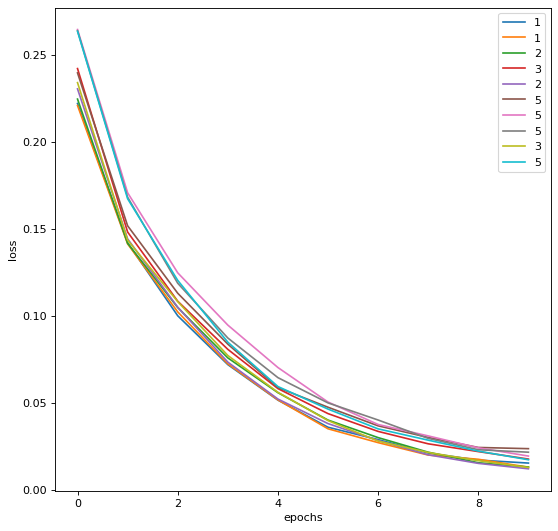

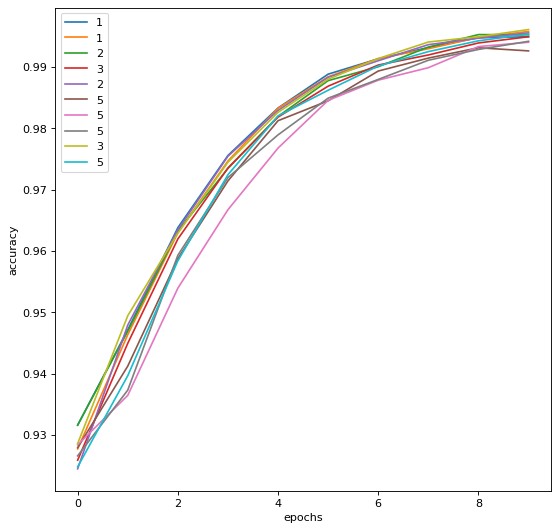

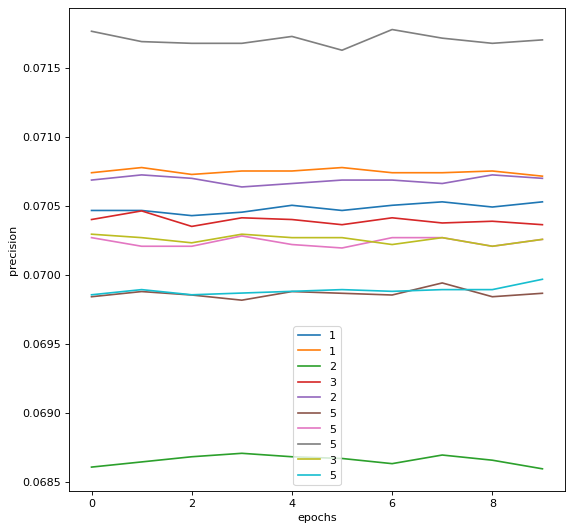

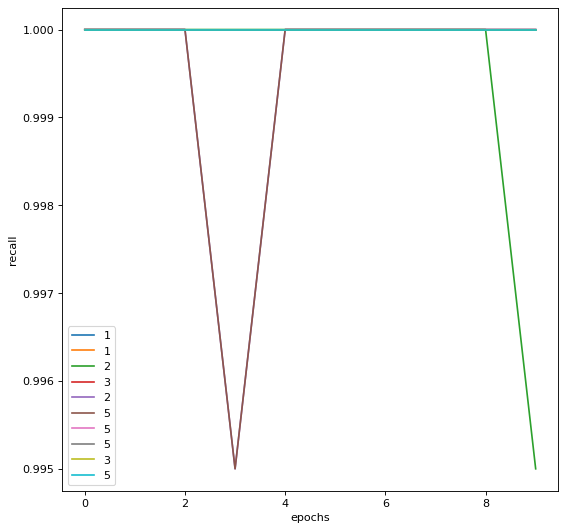

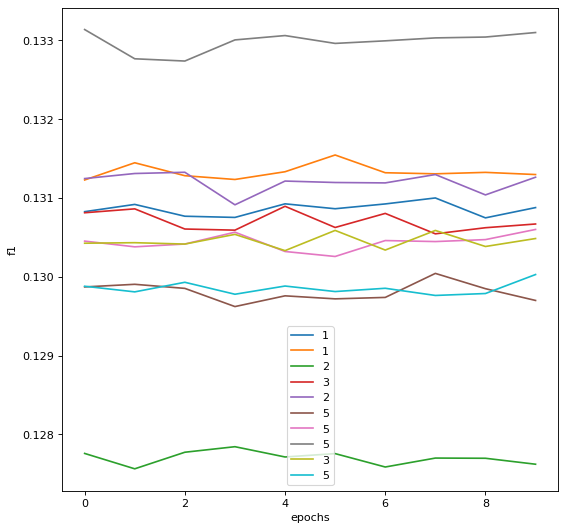

In [191]:
# def plot_graphs(axs, graph_index, history, string):
#     axs[graph_index].plot(history.history[string])
#     axs[graph_index].plot(history.history['val_'+string], '')
#     # axs[graph_index].xlabel("Epochs")
#     # axs[graph_index].ylabel(string)
#     axs[graph_index].set(xlabel="Epochs", ylabel=string)
#     axs[graph_index].legend([string, 'val_'+string])
#     # axs[graph_index].show()

# fig, axs = plt.subplots(2, figsize=(15, 15))
                        
# plot_graphs(axs, 0, data_history, 'accuracy')
# plot_graphs(axs, 1, data_history, 'loss')

from matplotlib.pyplot import figure

def plot_graphs(trials, parameter, metric):
    legends = []
    figure(figsize=(8, 8), dpi=80)
    for trial in trials:
        list_all_loss = trial.user_attrs[metric]
        legends.append(trial.params[parameter])
        plt.plot(list_all_loss)
    plt.xlabel("epochs")
    plt.ylabel(metric)
    plt.legend(legends)
    plt.savefig(metric + ".png")
    plt.show()

trials = num_hidden_nodes_study.get_trials()
parameter = "num_nodes_per_hidden_layer"

print(num_hidden_nodes_study.best_trial)

plot_graphs(trials, parameter, "loss")
plot_graphs(trials, parameter, "accuracy")
plot_graphs(trials, parameter, "precision")
plot_graphs(trials, parameter, "recall")
plot_graphs(trials, parameter, "f1")
